In [1]:
!pip install aif360

     |████████████████████████████████| 56.4MB 45.9MB/s 


In [2]:
!pip install BlackBoxAuditing

     |████████████████████████████████| 2.6MB 2.8MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=750f971e10654604bc62c67491a74672be7c857d3511c1478476f95ac1681418
  Stored in directory: /tmp/.cache/pip/wheels/66/82/7b/ac2a79b8caf97e15ed415162a7f272cbba1e2e2c851fa76ae3
Successfully built BlackBoxAuditing


In [3]:
!pip install numpy --upgrade

Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (1.17.0)


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib
from tqdm import tqdm
from IPython.display import Markdown, display


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from aif360.datasets import BinaryLabelDataset, StandardDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, classification_report 
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

['hiring']


## Import Data

In [5]:
df = pd.read_csv('../input/hiring/hiring-dataset.csv')

In [6]:
map_dict = {'No': 0, 'Yes': 1}
df['Hired'] = df['Hired'].apply(lambda x: map_dict[str(x)])

map_dict = {'F': 0, 'M': 1, 'nan': 2}
df['Candidate Gender'] = df['Candidate Gender'].apply(lambda x: map_dict[str(x)])
df['Manager Gender'] = df['Manager Gender'].apply(lambda x: map_dict[str(x)])
df['Recruiter Gender'] = df['Recruiter Gender'].apply(lambda x: map_dict[str(x)])

map_dict = {'nan': 0, 'Undisclosed': 0, 'White (not Hispanic or Latino)': 1, 'Hispanic or Latino': 2, 'Black or African American (not Hispanic or Latino)': 2, 
            'Asian (not Hispanic or Latino)': 2, 'American Indian or Alaska Native (not Hispanic or Latino)': 2, 'Native Hawaiian or Other Pacific Islander (not Hispanic or Latino)': 2} 
df['Ethnicity Type'] = df['Ethnicity Type'].apply(lambda x: map_dict[str(x)])

In [7]:
data_with_scores = df.dropna(subset=["iq", "ambition", "interpersonal", "creativity", "fluid_iq", "achievement", 
                                                   "achievement_striving", "agreeableness", "benevolence", "cog_flex", 
                                                   "collectivism", "core_self_evaluation", "curiosity", "extraversion", 
                                                   "neuroticism", "openness", "self_discipline", "total score"])

protected_class = ['Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Ethnicity Type', 'Candidate Is Internal', 'Candiate is disabled', 'Age (Years)', 
                   'Candidate Gender', 'Manager Gender', 'Recruiter Gender', 'Hired']

data_with_scores = data_with_scores[data_with_scores['Candidate Gender']!=2]


from sklearn.model_selection import StratifiedShuffleSplit

X = data_with_scores
y = data_with_scores['Hired']

Xtrain_, Xtest_, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 235)

Xtrain_['Hired'] = y_train
Xtest_['Hired'] = y_test
Xtrain_.to_csv('training_df.csv')
Xtest_.to_csv('test_df.csv')

X_train = Xtrain_.drop(protected_class, axis=1)

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

Label Distributions: 

[0.98686758 0.01313242]
[0.98669434 0.01330566]


In [8]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler()
# X_ros, y_ros = ros.fit_sample(X_train, y_train)

# X_train = X_ros
# y_train = y_ros

In [9]:
# log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# log_reg_cs = RandomizedSearchCV(LogisticRegression(class_weight={0:1,1:75}), log_reg_params, n_iter=4)
log_reg_cs = LogisticRegression(penalty='l2', C=1, class_weight={0:1,1:75})
log_reg_cs = log_reg_cs.fit(X_train, y_train)
# print('The best parameters are', log_reg_cs.best_params_)

In [10]:
joblib.dump(log_reg_cs, 'plain_lr_model.pkl') 

['plain_lr_model.pkl']

In [11]:
svc_cs = SVC(kernel = 'linear', C=1, class_weight={0:1,1:75}, probability=True)
svc_cs.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight={0: 1, 1: 75}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [12]:
joblib.dump(svc_cs, 'plain_svc_model.pkl') 

['plain_svc_model.pkl']

## Gender Bias

In [13]:
protected_class = ['Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Ethnicity Type', 'Candidate Is Internal', 'Candiate is disabled', 'Age (Years)', 
                   'Manager Gender', 'Recruiter Gender']

training = Xtrain_.drop(protected_class, axis=1)
test = Xtest_.drop(protected_class, axis=1)

In [14]:
privileged_sex = [1]
favorable_label = 1


original_training_dataset = StandardDataset(training, 
                               label_name='Hired', 
                               favorable_classes=[favorable_label], 
                               protected_attribute_names=['Candidate Gender'], 
                               privileged_classes=[privileged_sex])

original_test_dataset = StandardDataset(test, 
                               label_name='Hired', 
                               favorable_classes=[favorable_label], 
                               protected_attribute_names=['Candidate Gender'], 
                               privileged_classes=[privileged_sex])


index = original_test_dataset.feature_names.index('Candidate Gender')
X_test = np.delete(original_test_dataset.features, index, axis=1)
y_test = original_test_dataset.labels.ravel()

In [15]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'false_positive_rate_difference']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.false_positive_rate_difference()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.2]
    rect = [-0.1,-0.1,-0.1,0.8,-0.1]
    bottom = [-1,-1,-1,0,-1]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[-0.1,0.1]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:3].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:3], y=fair_metrics.iloc[1:3][cols[i]])

        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [16]:
def get_fair_metrics_and_plot(data, pred, plot=True, model_aif=False):
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

0.5395109455000698


### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Candidate Gender attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Candidate Gender,-0.028409,-0.140217,0.083578,0.936281,-0.026938


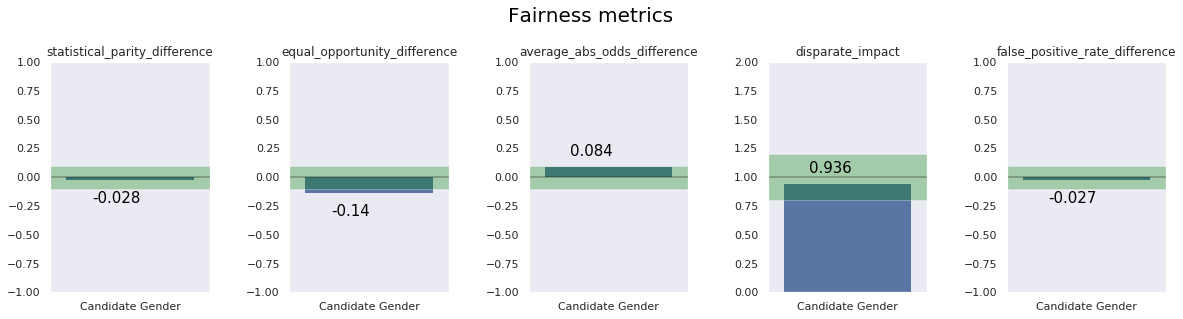

In [17]:
cs_pred_lr = log_reg_cs.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, cs_pred_lr)
roc_auc = auc(fpr,tpr)
print(roc_auc)
display(Markdown('### Bias metrics'))
fair = get_fair_metrics_and_plot(original_test_dataset, cs_pred_lr)

0.5289717801660978


### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Candidate Gender attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.00000,0.000000,0.000000,1.000000,0.000000
Candidate Gender,-0.01976,-0.119203,0.068822,0.960503,-0.018441


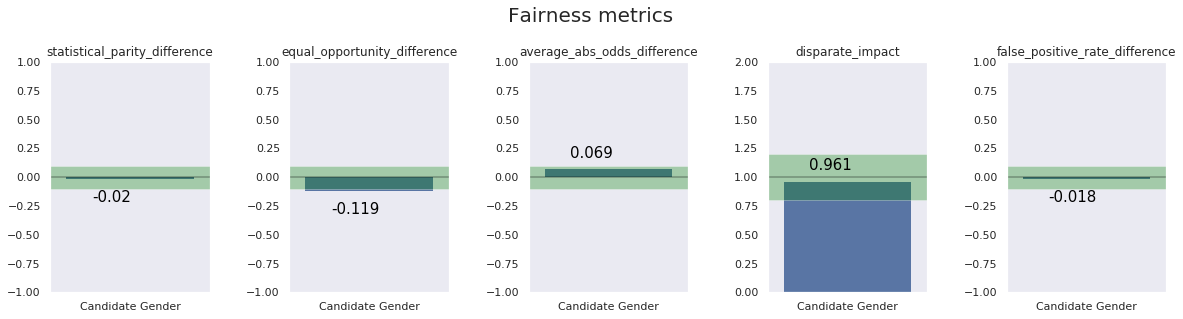

In [18]:
cs_pred_svc = svc_cs.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, cs_pred_svc)
roc_auc = auc(fpr,tpr)
print(roc_auc)
display(Markdown('### Bias metrics'))
fair = get_fair_metrics_and_plot(original_test_dataset, cs_pred_svc)

## Race

In [19]:
data_with_scores = df.dropna(subset=["iq", "ambition", "interpersonal", "creativity", "fluid_iq", "achievement", 
                                                   "achievement_striving", "agreeableness", "benevolence", "cog_flex", 
                                                   "collectivism", "core_self_evaluation", "curiosity", "extraversion", 
                                                   "neuroticism", "openness", "self_discipline", "total score"])

protected_class = ['Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Ethnicity Type', 'Candidate Is Internal', 'Candiate is disabled', 'Age (Years)', 
                   'Candidate Gender', 'Manager Gender', 'Recruiter Gender', 'Hired']

data_with_scores = data_with_scores[data_with_scores['Ethnicity Type']!=0]


from sklearn.model_selection import StratifiedShuffleSplit

X = data_with_scores
y = data_with_scores['Hired']

Xtrain_, Xtest_, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2368)

Xtrain_['Hired'] = y_train
Xtest_['Hired'] = y_test
Xtrain_.to_csv('training_df.csv')
Xtest_.to_csv('test_df.csv')

X_train = Xtrain_.drop(protected_class, axis=1)

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

Label Distributions: 

[0.99027001 0.00972999]
[0.9900681 0.0099319]


In [20]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_cs = RandomizedSearchCV(LogisticRegression(class_weight={0:1,1:100}), log_reg_params, n_iter=4)
# log_reg_cs = LogisticRegression(penalty='l2', C=1, class_weight={0:1,1:75})
log_reg_cs = log_reg_cs.fit(X_train, y_train)
print('The best parameters are', log_reg_cs.best_params_)

The best parameters are {'penalty': 'l2', 'C': 1000}


In [21]:
svc_cs = SVC(kernel = 'linear', C=1, class_weight={0:1,1:100})
svc_cs.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight={0: 1, 1: 100}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [22]:
protected_class = ['Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Candidate Is Internal', 'Candiate is disabled', 'Age (Years)', 
                   'Candidate Gender', 'Manager Gender', 'Recruiter Gender']

training = Xtrain_.drop(protected_class, axis=1)
test = Xtest_.drop(protected_class, axis=1)

In [23]:
test = test[test['Ethnicity Type']!=0]

original_Xtest = test.drop(['Hired'], axis=1)

privileged_race = [1]
favorable_label = 1


original_training_dataset_race = StandardDataset(training, 
                               label_name='Hired', 
                               favorable_classes=[favorable_label], 
                               protected_attribute_names=['Ethnicity Type'], 
                               privileged_classes=[privileged_sex])

original_test_dataset_race = StandardDataset(test, 
                               label_name='Hired', 
                               favorable_classes=[favorable_label], 
                               protected_attribute_names=['Ethnicity Type'], 
                               privileged_classes=[privileged_sex])


index = original_training_dataset_race.feature_names.index('Ethnicity Type')
X_train = np.delete(original_training_dataset_race.features, index, axis=1)
X_test = np.delete(original_test_dataset_race.features, index, axis=1)
y_train = original_training_dataset_race.labels.ravel()
y_test = original_test_dataset_race.labels.ravel()

In [24]:
cs_pred_lr = log_reg_cs.predict(X_test)
cs_pred_svc = svc_cs.predict(X_test)

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Ethnicity Type attribute :

With default thresholds, bias against unprivileged group detected in **2** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.00000,0.000000
Ethnicity Type,-0.079338,0.268939,0.175566,0.81908,-0.082193


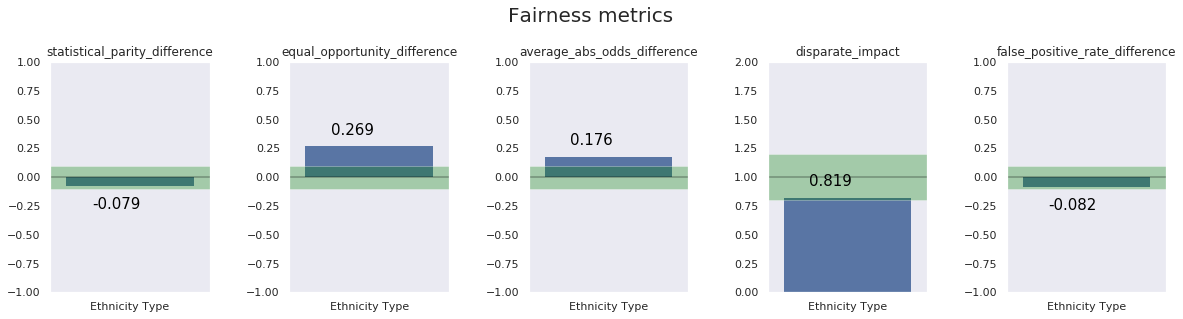

In [25]:
display(Markdown('### Bias metrics'))
fair = get_fair_metrics_and_plot(original_test_dataset_race, cs_pred_lr)

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Ethnicity Type attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.00000
Ethnicity Type,-0.062569,0.102273,0.082926,0.872185,-0.06358


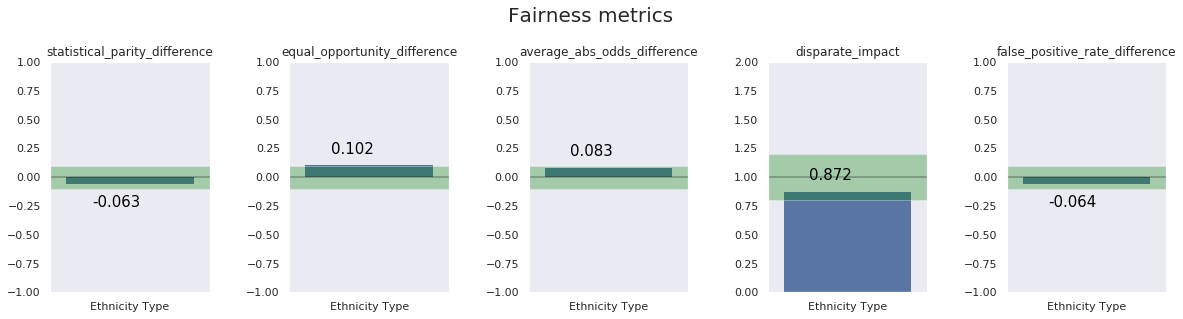

In [26]:
display(Markdown('### Bias metrics'))
fair = get_fair_metrics_and_plot(original_test_dataset_race, cs_pred_svc)